In [25]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install numexpr

In [26]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt
%matplotlib inline

### Lode data from TensorFloe Dataset

In [27]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

### TensorFlowが公開するデータセットの中からMovielensをロードする
## 評価データ行列をロード、tf.data.Datasetオブジェクトのratingが生成される
ratings_original = tfds.load('movielens/100k-ratings', split='train')
## 映画データ行列をロード、tf.data.Datasetオブジェクトのmoviesが生成される
movies_original = tfds.load('movielens/100k-movies', split='train')

movieDF = pd.read_csv("ml-25m/movies.csv")
rateDF = pd.read_csv("ml-25m/ratings.csv")

# Select the basic features.
ratings = ratings_original.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies_original.map(lambda x: x["movie_title"])

--2021-12-22 07:09:57--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip.1’

ml-25m.zip.1        100%[===================>] 249.84M  17.3MB/s    in 16s     

2021-12-22 07:10:14 (15.5 MB/s) - ‘ml-25m.zip.1’ saved [261978986/261978986]

Archive:  ml-25m.zip
replace ml-25m/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-25m/tags.csv         
replace ml-25m/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-25m/links.csv        
replace ml-25m/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-25m/README.txt       
replace ml-25m/ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-25m/ratings.csv      
replace ml-25m/genome-tags.csv? [y]es, [n]

In [28]:
embedding_dimension = 32

#### ランダムにトレーニングデータとテストデータに分割する
トレーニングデータ：８０％  
テストデータ：２０％

#### データに存在する一意のユーザーIDと映画のタイトルを把握する

In [29]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

#### 文字列を整数値に変換する
一意のユーザーIDを変換に用いる

In [30]:
user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add 1 to account for the unknown token.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

In [53]:
tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.Precision()],
)

In [32]:
tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128)
    )
)

#### モデルクラス

In [54]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.Precision()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["movie_title"])

    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)


#### モデルをインスタンス化する

In [55]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1), metrics=[tf.keras.metrics.Precision()])

#### トレーニングデータと評価データをシャッフル、バッチ処理、およびキャッシュする

In [56]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

#### モデルをトレーニングする

In [57]:
epochs = 3
model_hist = model.fit(cached_train, epochs=epochs)

Epoch 1/3
10/10 [==============================] - 29s 2s/step - root_mean_squared_error: 2.1006 - factorized_top_k/top_1_categorical_accuracy: 5.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0056 - factorized_top_k/top_50_categorical_accuracy: 0.0286 - factorized_top_k/top_100_categorical_accuracy: 0.0583 - loss: 4.0653 - regularization_loss: 0.0000e+00 - total_loss: 4.0653
Epoch 2/3
10/10 [==============================] - 24s 2s/step - root_mean_squared_error: 1.1552 - factorized_top_k/top_1_categorical_accuracy: 4.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0029 - factorized_top_k/top_10_categorical_accuracy: 0.0056 - factorized_top_k/top_50_categorical_accuracy: 0.0289 - factorized_top_k/top_100_categorical_accuracy: 0.0588 - loss: 1.3350 - regularization_loss: 0.0000e+00 - total_loss: 1.3350
Epoch 3/3
10/10 [==============================] - 24s 2s/step - root_mean_squared_error: 1.1372 - factorized_

#### テストセットでモデルを評価

In [46]:
model_evaluation =  model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 8s 879ms/step - root_mean_squared_error: 1.0869 - factorized_top_k/top_1_categorical_accuracy: 3.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0030 - factorized_top_k/top_10_categorical_accuracy: 0.0066 - factorized_top_k/top_50_categorical_accuracy: 0.0324 - factorized_top_k/top_100_categorical_accuracy: 0.0613 - loss: 1.1778 - regularization_loss: 0.0000e+00 - total_loss: 1.1778


In [47]:
model_evaluation

{'factorized_top_k/top_100_categorical_accuracy': 0.06129999831318855,
 'factorized_top_k/top_10_categorical_accuracy': 0.006550000049173832,
 'factorized_top_k/top_1_categorical_accuracy': 0.0003000000142492354,
 'factorized_top_k/top_50_categorical_accuracy': 0.03240000084042549,
 'factorized_top_k/top_5_categorical_accuracy': 0.003000000026077032,
 'loss': 1.1620267629623413,
 'regularization_loss': 0,
 'root_mean_squared_error': 1.0869065523147583,
 'total_loss': 1.1620267629623413}

In [39]:
model_evaluation_tmp = model_evaluation
for k in list(model_evaluation):
  if "factorized_top_k/" not in k:
    model_evaluation_tmp.pop(k)

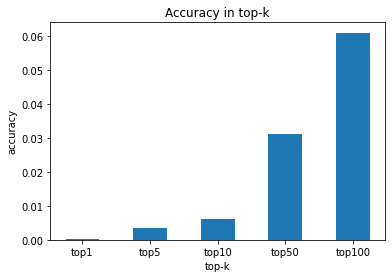

In [40]:
# top-kのリストを定義
top_k = [1, 5, 10, 50, 100]
# 棒グラフにおけるx軸のラベルを定義
label = ["top" + str(k) for k in top_k]
# 棒グラフのx軸の値（図を整えるために定義）
x_range = [1, 2, 3, 4, 5]

# y軸の値を保持するリストを定義
y = []
for k in top_k:
  # 各kにおけるtop-kの値をyにスタック
  y.append(model_evaluation["factorized_top_k/top_" + str(k) + "_categorical_accuracy"])

# 図示する
plt.bar(x_range, height=y, width=0.5, tick_label=label)  # 棒のラベルづけと幅の変更
plt.title("Accuracy in top-k")
plt.xlabel("top-k")
plt.ylabel("accuracy");

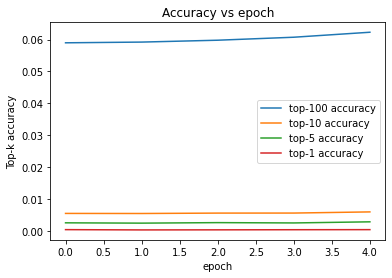

In [41]:
epochsLists = [i for i in range(epochs)]
plt.plot(epochsLists, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="top-100 accuracy")
plt.plot(epochsLists, model_hist.history["factorized_top_k/top_10_categorical_accuracy"], label="top-10 accuracy")
plt.plot(epochsLists, model_hist.history["factorized_top_k/top_5_categorical_accuracy"], label="top-5 accuracy")
plt.plot(epochsLists, model_hist.history["factorized_top_k/top_1_categorical_accuracy"], label="top-1 accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-k accuracy");
plt.legend()

In [42]:
top_k = 10
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=top_k)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

UID = input ("ユーザーのIDを入力してください:") 
 
# Get some recommendations.
rates, titles = index(np.array([UID]))
titles = [i.decode('UTF-8') for i in titles.numpy().flatten()]
rates = [r for r in rates.numpy().flatten()]

result = pd.DataFrame.from_dict({"title":titles, "rate":rates})
print("ユーザー:%sへお勧め映画は下記です：" %  UID)
result

ユーザーのIDを入力してください:100
ユーザー:100へお勧め映画は下記です：


,title,rate
0,Blues Brothers 2000 (1998),0.013412
1,Batman & Robin (1997),0.013257
2,Bogus (1996),0.012600
3,Independence Day (ID4) (1996),0.012172
4,Until the End of the World (Bis ans Ende der W...,0.012170
5,Nixon (1995),0.012138
6,Man of the House (1995),0.012069
7,Ready to Wear (Pret-A-Porter) (1994),0.011993
8,Trainspotting (1996),0.011867
9,"Boot, Das (1981)",0.011827
